In [57]:
# -------------------- Imports -------------------- #
import keras, pandas as pd, sys, numpy as np, math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 


plt.figure(figsize=(10, 10))

# -------------------- Globals -------------------- #
input_file = '../data/NSE:TCS.csv'
dataset = None
look_back = 365

verbosity = True
np.random.seed(66)


# -------------------- Data -------------------- #
def data_with_look_back(dataset):
    '''Returns x with look_back samples at time t and y with the sample at t+1 '''

    if len(dataset) < look_back:
        raise Exception("Dataset not large enough for given look back!")

    x, y = list(), list()
    for i in range(len(dataset) - look_back):
        x.append(dataset[i:look_back+i])
        y.append(dataset[look_back+i])
    
    return np.array(x), np.array(y)


# Get data
df = pd.read_csv(input_file, usecols=['timestamp', 'close'])
dataset = df['close'].astype('float32')
dataset = dataset[::-1]

if verbosity:
    print("Most recent data point at :", df['timestamp'][0], ":", dataset[len(dataset) - 1])
    print("Oldest data point at :", df['timestamp'][len(df['timestamp']) - 1], ":", dataset[0])

for i in range(len(dataset)):       # replace missing values with mean of prev and next
    if dataset[i] == 0:
        dataset[i] = np.mean([dataset[i-1], dataset[i+1]])

dataset = dataset.values.reshape((-1, 1))

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Train and test
l = len(dataset) * 60 // 100
train_data = dataset[:l]
test_data = dataset[l:]

print("Length of training set =", len(train_data))
print("Length of test data =", len(test_data))

Most recent data point at : 2018-03-23 : 246.988
Oldest data point at : 2004-08-25 : 2818.15
Length of training set = 2018
Length of test data = 1346


<Figure size 720x720 with 0 Axes>

In [47]:
train_x, train_y = data_with_look_back(train_data)
test_x, test_y = data_with_look_back(test_data)

train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))

verbose = 0

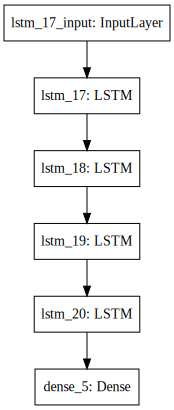

In [48]:
# -------------------- Model -------------------- #
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back), return_sequences=True))
model.add(LSTM(10, input_shape=(1, look_back), return_sequences=True))
model.add(LSTM(5, input_shape=(1, look_back), return_sequences=True))
model.add(LSTM(5, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_x, train_y, epochs=100, batch_size=30, verbose=verbose)

trainPredict = model.predict(train_x)
testPredict = model.predict(test_x)

# -------------------- Plot Model -------------------- #

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [49]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
train_y = scaler.inverse_transform(train_y)
testPredict = scaler.inverse_transform(testPredict)
test_y = scaler.inverse_transform(test_y)

# calculate average error
trainScore = np.mean([math.fabs(x - y) for x, y in zip(train_y, trainPredict)])
print('Average Error in Training set predictions: %.2f ' % (trainScore))
testScore = np.mean([math.fabs(x - y) for x, y in zip(test_y, testPredict)])
print('Average Error in Test set predictions: %.2f ' % (testScore))

print('\n')

# calculate RMSE
trainScore = math.sqrt(np.mean([math.fabs(x - y)**2 for x, y in zip(train_y, trainPredict)]))
print('Average RMSE in Training set predictions: %.2f ' % (trainScore))
testScore = math.sqrt(np.mean([math.fabs(x - y)**2 for x, y in zip(test_y, testPredict)]))
print('Average RMSE in Test set predictions: %.2f ' % (testScore))

Average Error in Training set predictions: 18.22 
Average Error in Test set predictions: 967.21 


Average RMSE in Training set predictions: 23.49 
Average RMSE in Test set predictions: 979.78 


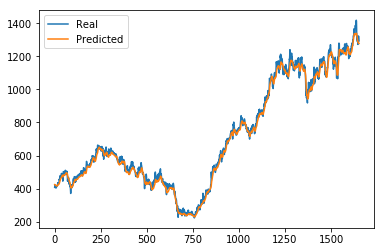

In [50]:
# Predicted Vs Original of train set

plt.plot(train_y, label='Real')
plt.plot(trainPredict, label='Predicted')
plt.legend()
plt.show()

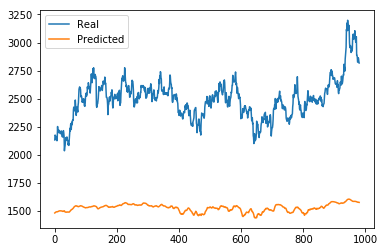

In [51]:
# Predicted Vs Original of train set

plt.plot(test_y, label='Real')
plt.plot(testPredict, label='Predicted')
plt.legend()
plt.show()

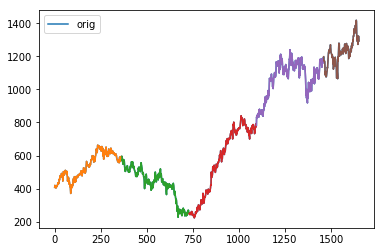

In [52]:
# Print direction of growth - test set - take one month, predict the next year's values
batchSize = 365
end = False
plt.plot(train_y, label='orig')
orig = scaler.transform(train_y)
orig.reshape(orig.shape[0])
for i in range(0, len(train_y)+1, batchSize):
    o = orig[i:i+look_back]
    p = list(o[:])
    for j in range(int(math.fabs(batchSize-look_back))):
 #       try:
        p.append(model.predict(o.reshape((1, 1, look_back)))[0])
            #print(o.reshape((1, 1, look_back)))
#        except:
            #end = True
#            break
        o = list(o[1:])
        o.append(p[-1])
        o = np.array(o)
    if end:
        break
    p = scaler.inverse_transform(p)
    plt.plot(range(i, i+len(p)), p)

orig = scaler.inverse_transform(orig)

plt.legend()
plt.show()

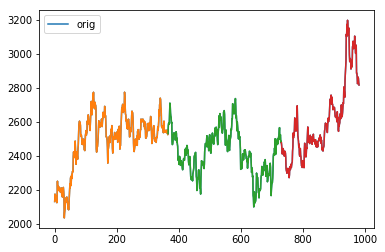

In [53]:
# Print direction of growth - test set - take one month, predict the next year's values
batchSize = 365
end = False
plt.plot(test_y, label='orig')
orig = scaler.transform(test_y)
orig.reshape(orig.shape[0])
for i in range(0, len(test_y)+1, batchSize):
    o = orig[i:i+look_back]
    p = list(o[:])
    for j in range(int(math.fabs(batchSize-look_back))):
 #       try:
        p.append(model.predict(o.reshape((1, 1, look_back)))[0])
            #print(o.reshape((1, 1, look_back)))
#        except:
            #end = True
#            break
        o = list(o[1:])
        o.append(p[-1])
        o = np.array(o)
    if end:
        break
    p = scaler.inverse_transform(p)
    plt.plot(range(i, i+len(p)), p)

orig = scaler.inverse_transform(orig)

plt.legend()
plt.savefig(input_file.split('/')[-1].split('.')[0] + '.png', format='png')
plt.show()

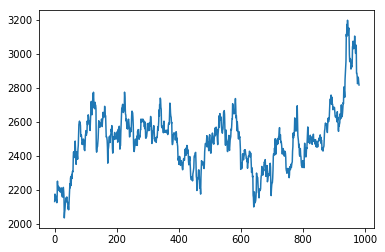

In [54]:
plt.plot(orig, label='orig')
plt.show()

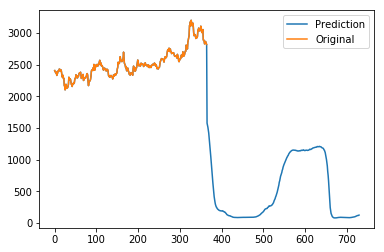

In [55]:
import copy
orig = scaler.transform(test_y)
o = orig[-365:]
p = list(o[:])
for i in range(365):
    p.append(model.predict(o.reshape((1, 1, look_back)))[0])
            #print(o.reshape((1, 1, look_back)))
#        except:
            #end = True
#            break
    o = list(o[1:])
    o.append(p[-1])
    o = np.array(o)
p = scaler.inverse_transform(p)
plt.plot(range(len(p)), p, label='Prediction')

o = scaler.inverse_transform(orig[-365:])
plt.plot(o, label='Original')
plt.legend()
plt.savefig('next' + input_file.split('/')[-1].split('.')[0] + '.png', format='png')
plt.show()

In [56]:
print(p[30])
print(p[120])
print(p[-1])

[2132.89994813]
[2441.00006677]
[126.84236]
